In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from models.building.building import BuildingModel
from models.heat_pump.heat_pump import HeatPumpEventBased, HeatPumpWControlEventBased
from models.weather.weather import SynproWeather
from simplec_examples.models.hyst_controller import HystController 
from simplec import Simulation

In [ ]:
sim = Simulation()

# Building Envelope
weather    = SynproWeather(name='weather')
building   = BuildingModel('building')
heatpump   = HeatPumpWControlEventBased('heatpump', eta=0.4, dot_Q_hp_nom=15000, P_el_max=4000, P_el_min=1000)
controller = HystController('controller', hyst=2.)


# Appartment 1
## Electric consumption
## DHW constumption
## Smart meter


# Appartment 2


# Appartment 3




sim.add_model(building,   watch_values=['T_building']  )
sim.add_model(heatpump,   watch_values=['state', 'P_el', 'dot_Q_hp'])
sim.add_model(controller, watch_values=['T_is', 'state'])
sim.add_model(weather,    watch_values=['T_amb', 'I_dir', 'I_dif', 'I_s', 'I_w', 'I_n', 'I_e'])

sim.connect(heatpump, building, ('dot_Q_hp', 'dot_Q_heat'))
sim.connect(controller, heatpump, ('state', 'state'), triggers=['state'])
sim.connect(weather, building, 'T_amb', 'I_dir', 'I_dif', 'I_s', 'I_w', 'I_n', 'I_e')
sim.connect(weather, heatpump, ('T_amb', 'T_source'))

sim.connect_constant(0.0, building, 'dot_Q_cool', 'dot_Q_int')

sim.connect(building, heatpump, ('T_building', 'T_sink'), time_shifted=True, init_values={'T_building': 21})
sim.connect(building, controller, ('T_building', 'T_is'), time_shifted=True, init_values={'T_building': 21})

times = pd.date_range('2017-01-01 00:00:00', '2017-01-03 00:00:00', freq='1min', tz='UTC+01:00')

In [14]:
sim.run(times)

Progress: 100%|██████████| 2881/2881 [00:09<00:00, 303.85Steps/s]


In [15]:
# Attempt to convert df to numeric
df = sim.df
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col])
df = df.ffill()
df.head()

C:\Users\seva\AppData\Local\Temp\ipykernel_7160\3468714922.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col])


model                       building heatpump                        \
i/o                          outputs   inputs      outputs            
attribute                 T_building    state         P_el dot_Q_hp   
2017-01-01 00:00:00+01:00  19.989834      off     0.000000      0.0   
2017-01-01 00:01:00+01:00  19.998763       on  2453.372690  15000.0   
2017-01-01 00:02:00+01:00  20.007694       on  2452.947796  15000.0   
2017-01-01 00:03:00+01:00  20.016627       on  2452.523150  15000.0   
2017-01-01 00:04:00+01:00  20.025562       on  2452.098751  15000.0   

model                     controller           weather                        \
i/o                           inputs outputs   outputs                         
attribute                       T_is   state     T_amb I_dir I_dif  I_s  I_w   
2017-01-01 00:00:00+01:00  21.000000     off  0.800000   0.0   0.0  0.0  0.0   
2017-01-01 00:01:00+01:00  19.989834      on  0.811667   0.0   0.0  0.0  0.0   
2017-01-01 00:02:00+01:00  19.998763      on  0.823333   0.0   0.0  0.0  0.0   
2017-01-01 00:03:00+01:00  20.007694      on  0.835000   0.0   0.0  0.0  0.0   
2017-01-01 00:04:00+01:00  20.016627      on  0.846667   0.0   0.0  0.0  0.0   

model                                
i/o                                  
attribute                  I_n  I_e  
2017-01-01 00:00:00+01:00  0.0  0.0  
2017-01-01 00:01:00+01:00  0.0  0.0  
2017-01-01 00:02:00+01:00  0.0  0.0  
2017-01-01 00:03:00+01:00  0.0  0.0  
2017-01-01 00:04:00+01:00  0.0  0.0

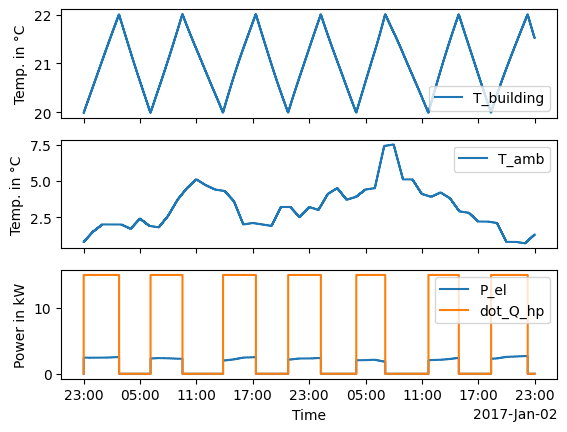

In [16]:
dtindex = df.index 

fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(dtindex, df.loc[:, ('building', 'outputs', 'T_building')], label='T_building', drawstyle='steps')
ax[0].legend()
ax[0].set_ylabel('Temp. in °C')

# Roomtemperatures
ax[1].plot(dtindex, df.loc[:, ('weather', 'outputs', 'T_amb')], label='T_amb', drawstyle='steps')
ax[1].legend()
ax[1].set_ylabel('Temp. in °C')

ax[2].plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'P_el')]/1000, label='P_el', drawstyle='steps')
ax[2].plot(dtindex, df.loc[:, ('heatpump', 'outputs', 'dot_Q_hp')]/1000, label='dot_Q_hp', drawstyle='steps')
ax[2].legend()
ax[2].set_ylabel('Power in kW')

ax[-1].set_xlabel('Time')
ax[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[-1].xaxis.get_major_locator(),))